# Load Libraries

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.cm import get_cmap
from cmcrameri import cm

This notebook includes calculations to show that water-rich mafic magmas can assimilate relatively high masses of sulfides, adding S and Cu to the melt and exsolving hydrous fluids. 

In [19]:
# Import modelled dataframe output in script (Sulfide saturation and degassing model - Jan 2024.ipynb)
buff = pd.read_csv('before_degassing_sulfsat.csv')

In [20]:
# print unique model runs - i.e. each run for a given pressure-H2O-QFM combination:
buff['unique'].unique()

array(['P_10000.0_H2O_0.1_QFM1.2', 'P_10000.0_H2O_0.0_QFM1.2',
       'P_10000.0_H2O_6.0_QFM1.2', 'P_10000.0_H2O_3.0_QFM1.2',
       'P_10000.0_H2O_1.0_QFM1.2', 'P_8000.0_H2O_0.0_QFM1.2',
       'P_8000.0_H2O_6.0_QFM1.2', 'P_8000.0_H2O_3.0_QFM1.2',
       'P_8000.0_H2O_0.1_QFM1.2', 'P_8000.0_H2O_1.0_QFM1.2',
       'P_4000.0_H2O_0.0_QFM1.2', 'P_4000.0_H2O_6.0_QFM1.2',
       'P_4000.0_H2O_3.0_QFM1.2', 'P_4000.0_H2O_1.0_QFM1.2',
       'P_4000.0_H2O_0.1_QFM1.2', 'P_2000.0_H2O_3.0_QFM1.2',
       'P_2000.0_H2O_0.0_QFM1.2', 'P_2000.0_H2O_6.0_QFM1.2',
       'P_2000.0_H2O_1.0_QFM1.2', 'P_2000.0_H2O_0.1_QFM1.2',
       'P_1000.0_H2O_0.0_QFM1.2', 'P_1000.0_H2O_3.0_QFM1.2',
       'P_1000.0_H2O_1.0_QFM1.2', 'P_1000.0_H2O_6.0_QFM1.2',
       'P_500.0_H2O_0.0_QFM1.2', 'P_500.0_H2O_6.0_QFM1.2',
       'P_500.0_H2O_3.0_QFM1.2', 'P_500.0_H2O_1.0_QFM1.2'], dtype=object)

In [21]:
# slice our modelled dataframe for MAFIC - SULFIDE UNDERSATURATED - SHALLOW - WATER-RICH MAGMAS
# slice according to the 'unique' column of the dataframe to find a shallow and water-rich model
# slice according to the 'SiO2_Liq' column of the dataframe to find mafic compositions only
# e.g.:
test_data_1 = buff[(buff['unique'].isin(['P_1000.0_H2O_6.0_QFM1.2'])) &  (buff['SiO2_Liq'] < 60)]

In [22]:
test_data_1.shape

(50, 405)

In [23]:
# melt fraction intervals to track fractional crystallisation evolution of the melt
targets = [1, 0.9, 0.8, 0.7, 0.6] 

# Find the index of the closest value to each target
closest_indices = [((test_data_1['melt_f'] - target).abs()).idxmin() for target in targets]

# Select the rows based on the closest indices and reset the index
syst_mass = test_data_1.loc[closest_indices].reset_index(drop=True)

# Add the 'targets' column
syst_mass['targets'] = [targets[((syst_mass['melt_f'] - target).abs()).idxmin()] for target in targets]


In [24]:
syst_mass['SiO2_Liq']

0    47.481633
1    48.332350
2    49.804222
3    50.868422
4    52.591568
Name: SiO2_Liq, dtype: float64

## Calculating the mass of S and Cu added to the melt per 0.1 g of sulfide (CuFeS2).

In [25]:
# stoichiometric calcs of CuFeS2

CuFeS2_gmol = 183.54
Cu_gmol = 63.55
Fe_gmol = 55.85
S_gmol = 32.07

CuFeS2_g = 0.1 # change depending on the mass of sulfide you wish to add

CuFeS2_mol = CuFeS2_g / CuFeS2_gmol

Cu_mol = CuFeS2_mol
S_mol = 2 * CuFeS2_mol

Cu_g = Cu_gmol * Cu_mol
S_g = S_gmol * S_mol

S_g, Cu_g

(0.03494606080418438, 0.03462460499073772)

##  Modelling Cl and S degassing

In [26]:
## INPUT INITIAL Cl CONCENTRATIONS HERE (PPM)
input_dict = {'S':1000,'Cl':1000} 

for key,val in input_dict.items():
    print(key,val)
    # initial concentration (ppm) of S and Cl in system
    syst_mass['initial_'+ key] = val
    
    # bulk concentration (ppm) of S and Cl in system 
    syst_mass['bulk_'+ key +'_ppm'] = syst_mass['initial_'+ key] / syst_mass['melt_f']
    
    # mass (g) of S and Cl in melt + fluid - ISSUE WITH INCREASING MASS SLIGHTLY
    syst_mass['M_bulk_'+ key] = (syst_mass['fluid_cum_sum_H2O'] + syst_mass['mass_Liq'])*(syst_mass['bulk_'+ key +'_ppm']/10**6) 

    # G; mass fraction of S and Cl in the melt relative to the fluid
    syst_mass['G'] = syst_mass['mass_Liq'].div(syst_mass['fluid_cum_sum_H2O'])
    syst_mass['G'].replace([np.inf, -np.inf], 0, inplace=True)
    
    # calc mass of S total and Cu in mixed melt
    syst_mass['M_mix_Stot_melt'] = S_g + syst_mass['M_bulk_S']

    # check that correct mass of S added to each
    mass_bal = (syst_mass['M_mix_Stot_melt'] - syst_mass['M_bulk_S']) /  S_g
    
    print(mass_bal)

S 1000
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
dtype: float64
Cl 1000
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
dtype: float64


In [27]:
Kd_dict = {'S':'DS_fm','Cl':'DCl_fm'} 
for key,val in Kd_dict.items():
    
    syst_mass[key] = syst_mass[val]  
    
    # fluid-melt partition coefficient of S or Cl divided by respected G factor
    syst_mass[key +'_D/G'] = syst_mass[val].div(syst_mass['G'])
    syst_mass[key +'_D/G'].replace([np.inf, -np.inf], 0, inplace=True) 
 
    # mass (g) of S and Cl partitioning into fluid
    syst_mass['M_fluid_Cl'] = syst_mass['M_bulk_'+ key]*(syst_mass[key +'_D/G'] / (syst_mass[key +'_D/G']+1))
    
    syst_mass['M_fluid_S'] = syst_mass['M_mix_Stot_melt']*(syst_mass[key +'_D/G'] / (syst_mass[key +'_D/G']+1))
    
    syst_mass['M_fluid_'+key].replace([np.inf, -np.inf], 0, inplace=True) 
     
    # mass (g) of S and Cl in melt following fluid exsolution
    syst_mass['M_melt_Cl'] = syst_mass['M_bulk_Cl'] - syst_mass['M_fluid_Cl']

    syst_mass['M_melt_S'] = syst_mass['M_mix_Stot_melt'] - syst_mass['M_fluid_S']
        
    # check bulk mass (g) of S and Cl in fluid and melt
    syst_mass['M_bulk_Cl_check'] = (syst_mass['M_melt_Cl']+syst_mass['M_fluid_Cl']).div(syst_mass['M_bulk_Cl'])
    
    syst_mass['M_bulk_S_check'] = (syst_mass['M_melt_S']+syst_mass['M_fluid_S']).div(syst_mass['M_mix_Stot_melt'])

    # concentration (ppm) of S and Cl in fluid
    syst_mass['fluid_'+key+'_ppm'] = 1000000 * syst_mass['M_fluid_'+key].div(syst_mass['fluid_cum_sum_H2O'])#
    syst_mass['fluid_'+key+'_ppm'] = syst_mass['fluid_'+key+'_ppm'].fillna(0)

    
    # concentration (ppm) of S and Cl in melt following fluid exsolution
    syst_mass['melt_'+key+'_ppm'] = 1000000 * syst_mass['M_melt_'+key].div(syst_mass['mass_Liq'])
    syst_mass['melt_'+key+'_ppm'] = syst_mass['melt_'+key+'_ppm'].fillna(0)
  
    # Cl molinity of fluid (moles/kg)
    syst_mass['mCl_fluid'] = (syst_mass['fluid_Cl_ppm']* 10**-6) / (35*10**-3)
    #1000 * (syst_mass['M_fluid_Cl']/35)/syst_mass['fluid_cum_sum_H2O']#
    
    # mole fraction Cl in fluid
    syst_mass['molXCl_fluid'] = 100 * (syst_mass['M_fluid_Cl']/35).div((syst_mass['M_fluid_Cl']/35) + (syst_mass['fluid_cum_sum_H2O']/18))#

    # NaCl (wt%) in fluid
    syst_mass['NaCl_fluid'] = (syst_mass['fluid_Cl_ppm'] * 10**-4) * (58/35)
    #100*(((syst_mass['M_fluid_Cl']/35)*22.99)+syst_mass['M_fluid_Cl'])/syst_mass['fluid_cum_sum_H2O']#
    
    syst_mass['DCu_fm'] = (30 * (syst_mass['NaCl_fluid'] - 0.4) / 8) + 2

In [28]:
import warnings
warnings.filterwarnings('ignore', category=pd.core.generic.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

metal_Kd_dict = {'Cu':'DCu_fm'}                 
input_metal_dict = {'Cu':75} #'Ag':0.03,'Au':0.0033,'Se':0.14,'Re':0.001,'Te':0.5}

for key,val in metal_Kd_dict.items():
    #fluid-melt partition coefficient of chalcophile elements
    # divided by respected G factor
    syst_mass[key + '_D/G'] = syst_mass[val].div(syst_mass['G'])

for key,val in input_metal_dict.items():
    # initial chalcophile element concentration (ppm)
    syst_mass['initial_'+ key] = val
    
    # bulk chalcophile element concentration (ppm)
    syst_mass['bulk_'+ key +'_ppm'] = syst_mass['initial_'+ key] / (syst_mass['melt_f']+ syst_mass['fluid_cum_sum_H2O'])
    
    # bulk chalcophile element mass (g) 
    syst_mass['M_bulk_'+ key] = (syst_mass['fluid_cum_sum_H2O'] + syst_mass['mass_Liq'])*(syst_mass['bulk_'+ key +'_ppm']/10**6)
     
    # calc mass of  Cu in mixed melt
    syst_mass['M_mix_Cu_melt'] = Cu_g + syst_mass['M_bulk_Cu']
    
    # mass chalcophile element in fluid (g)
    syst_mass['M_fluid_Cu'] = (syst_mass['M_mix_Cu_melt']*syst_mass[key +'_D/G']) / (syst_mass[key +'_D/G']+1)
    syst_mass['M_fluid_Cu'] = syst_mass['M_fluid_Cu'].fillna(0)
    
    # mass chalcophile element remaining in the melt (g)
    syst_mass['M_melt_Cu'] = syst_mass['M_mix_Cu_melt'] - syst_mass['M_fluid_Cu']
    
    # chalcophile element concentration (ppm) in fluid
    syst_mass['fluid_Cu_ppm'] = 1000000 * syst_mass['M_fluid_Cu'].div(syst_mass['fluid_cum_sum_H2O'])#

    # chalcophile element concentration (ppm) in melt
    syst_mass['melt_Cu_ppm'] = 1000000 * syst_mass['M_melt_Cu'].div(syst_mass['mass_Liq'])


In [29]:
# chalcophile element sulfide-silicate melt partition coefficients

# sulfide liquid - silicate melt partition coeffcient for Cu from Kiseeva and Wood 2015
syst_mass['DCu_sl'] = 10**((-0.823 * np.log10(syst_mass['FeOt_Liq'])) + 3.334)

# monosulfide solid solution - silicate melt partition coeffcient for Cu from Li and Audetat
syst_mass['DCu_mss'] = 10**(1.18+(0.28*(10000/(syst_mass['T_C']+273.15)))+(-0.05*(syst_mass['DeltaQFM_frostbuff']))+(-0.66*np.log10(syst_mass['FeOt_Liq'])))

# combined Kd
syst_mass['DCu_sulfsil'] = syst_mass.apply(lambda row: row['DCu_sl'] if row['FeOt_Liq'] > 3.6 else row['DCu_mss'], axis=1)

## Modeling sulfide saturation 

We run this section of the code multiple times 

In [30]:
dfnew = syst_mass.copy()
dfnew.targets

0    1.0
1    0.9
2    0.8
3    0.7
4    0.6
Name: targets, dtype: float64

In [31]:
# Check that our penultimate column has non NaN values - this is important
# for the iteration loop below. 
for u in dfnew.targets.unique():
    syst_mass = dfnew[dfnew['targets'].isin([u])].copy()
    print(f"DataFrame final row {u}:\n", syst_mass['S_D/G'].iloc[0])

DataFrame final row 1.0:
 0.027876098097830048
DataFrame final row 0.9:
 0.03249279660330177
DataFrame final row 0.8:
 0.04012996532959241
DataFrame final row 0.7:
 0.06356182401668738
DataFrame final row 0.6:
 0.12083957986851349


In [32]:
# Ignore warnings
warnings.filterwarnings('ignore', category=pd.core.generic.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

# Define columns to be filled in this loop and changed
dfnew[['melt_S2_ppm', 'satmelt_S2_ppm', 'melt_S6_ppm', 'GG', 'S_sulfide_ppm', 'M_S_sulfide', 'DS_sulfsil',
           'M_S_sulf_cumu', 'melt_Stot_ppm', 'M_satmelt_S', 'sulfide_Cu_ppm']] = 0.0

# Change depending on model requirements
eqbm_dict = {'S': 'M_mix_Stot_melt', 'Cu': 'M_mix_Cu_melt'}
metal_sulfide_dict = {'Cu':'DCu_sulfsil'}

# Create an empty dictionary to store DataFrames
result_dataframes = {}

max_iterations = 100  # Set the desired number of iterations

for u in dfnew.targets.unique():
    syst_mass = dfnew[dfnew['targets'].isin([u])].copy()
    
    # Initialize a counter for testing
    iteration_counter = 0
    condition_met = True
    
    while condition_met: 

        if iteration_counter == 0:
            syst_mass['melt_S2_ppm'] = syst_mass['melt_S_ppm'] * (1 - syst_mass['jugo_s6st'])
        else:
            syst_mass['melt_S2_ppm'] = syst_mass['new_Cmelt_S2']
        # Calculate S_sulfide_ppm and satmelt_S2_ppm
        syst_mass['S_sulfide_ppm'] = syst_mass['melt_S2_ppm'].sub(syst_mass['SCSS_OM21']).clip(0)
        syst_mass['satmelt_S2_ppm'] = syst_mass['melt_S2_ppm'].sub(syst_mass['S_sulfide_ppm'])

        # Calculate M_S_sulfide and M_S_sulf_cumu
        syst_mass['M_S_sulfide'] = (syst_mass['mass_Liq'] + syst_mass['fluid_cum_sum_H2O']) * syst_mass['S_sulfide_ppm'] / 10 ** 6
        syst_mass['M_S_sulf_cumu'] += syst_mass['M_S_sulfide']

        # Calculate melt_S6_ppm
        syst_mass['melt_S6_ppm'] = syst_mass['melt_S_ppm'] * syst_mass['jugo_s6st']
        syst_mass['melt_S6_ppm'] = syst_mass['melt_S6_ppm'].where(syst_mass['melt_S6_ppm'] < syst_mass['SCAS'], syst_mass['SCAS'])

        # Calculate melt_Stot_ppm and M_satmelt_S
        syst_mass['melt_Stot_ppm'] = syst_mass['melt_S6_ppm'] + syst_mass['satmelt_S2_ppm']
        syst_mass['M_satmelt_S'] = syst_mass['melt_Stot_ppm'] * (syst_mass['mass_Liq'] / 10 ** 6)

        # Calculate DS_sulfsil
        syst_mass['DS_sulfsil'] = 50 / (syst_mass['melt_Stot_ppm'] / 10000)
        

        # Calculate GG
        syst_mass['GG'] = syst_mass['mass_Liq'] / (3 * syst_mass['M_S_sulfide']).where(syst_mass['M_S_sulfide'] > 0, 0)

        # Calculate metal_sulfide_dict
        for key, val in metal_sulfide_dict.items():
            syst_mass[key + '_D/GG'] = syst_mass[val] / syst_mass['GG'].where(syst_mass['GG'] > 0, 1)

            syst_mass['totM_' + key + '_sulfide+melt'] = ((3 * syst_mass['M_S_sulfide']) + syst_mass['mass_Liq']) * syst_mass['melt_' + key + '_ppm'] / 10**6
            syst_mass['M_' + key + '_sulfide'] = syst_mass['totM_' + key + '_sulfide+melt'] * syst_mass[key + '_D/GG'] / (syst_mass[key + '_D/GG'] + 1)
            syst_mass['M_melt_' + key + '_final'] = syst_mass['totM_' + key + '_sulfide+melt'] - syst_mass['M_' + key + '_sulfide']

            # concentration (ppm) of chalcophile element in melt after sulfide phase and fluids formed
            syst_mass['melt_'+key+'_ppm_final'] = 1000000 * syst_mass['M_melt_'+key+'_final'].div(syst_mass['mass_Liq'])

            syst_mass['sulfide_' + key + '_ppm'] = 1000000 * syst_mass['M_' + key + '_sulfide'] / (2 * syst_mass['M_S_sulfide']).where(syst_mass['M_' + key + '_sulfide'] > 0, 0)


            # equilibration steps
        syst_mass['Xfluid'] = syst_mass['fluid_cum_sum_H2O'].div(syst_mass['i_M_fluid']+syst_mass['i_M_melt']+syst_mass['i_M_solid'])

        syst_mass['Xsulf'] = (2*syst_mass['M_S_sulf_cumu']).div(syst_mass['i_M_fluid']+syst_mass['i_M_melt']+syst_mass['i_M_solid'])

        syst_mass['Xmelt'] = syst_mass['mass_Liq'].div(syst_mass['i_M_fluid']+syst_mass['i_M_melt']+syst_mass['i_M_solid'])

        syst_mass['Xsolid'] = syst_mass['M_solid'].div(syst_mass['i_M_fluid']+syst_mass['i_M_melt']+syst_mass['i_M_solid'])

        syst_mass['Xtotal'] = syst_mass['Xfluid'] + syst_mass['Xsulf'] + syst_mass['Xmelt'] + syst_mass['Xsolid']

        syst_mass['Xfluid_norm'] = syst_mass['Xfluid'] / syst_mass['Xtotal']

        syst_mass['Xsulf_norm'] = syst_mass['Xsulf'] / syst_mass['Xtotal']

        syst_mass['Xmelt_norm'] = syst_mass['Xmelt'] / syst_mass['Xtotal']

        syst_mass['Xsolid_norm'] = syst_mass['Xsolid'] / syst_mass['Xtotal']

        syst_mass['Xtotal_norm'] = syst_mass['Xtotal'] / syst_mass['Xtotal']

        for key, val in eqbm_dict.items():

            syst_mass['CiXi_' + key] = (syst_mass[val]) * syst_mass['Xtotal_norm'] #might need div by 10**4

            syst_mass['new_Cmelt_' + key] = syst_mass['CiXi_' + key] / (syst_mass['Xmelt_norm'] + (syst_mass['Xfluid_norm'] * syst_mass['D' +key+'_fm']) + (syst_mass['Xsulf_norm'] * syst_mass['D'+key+'_sulfsil']))

            syst_mass['new_Cfluid_' + key] = np.where(syst_mass['Xfluid_norm'] == 0, 0,syst_mass['D'+key+'_fm'] * syst_mass['new_Cmelt_' + key])

            syst_mass['new_Csulf_' + key] = np.where(syst_mass['Xsulf_norm'] == 0, 0,syst_mass['D'+key+'_sulfsil'] * syst_mass['new_Cmelt_' + key])

            syst_mass['new_Mmelt_'+key] = syst_mass['new_Cmelt_'+key] * syst_mass['Xmelt_norm']

            syst_mass['new_Mfluid_'+key] = syst_mass['new_Cfluid_'+key] *syst_mass['Xfluid_norm']

            syst_mass['new_Msulf_'+key] = syst_mass['new_Csulf_'+key] *syst_mass['Xsulf_norm']

            syst_mass['new_tot_mass_check_'+key] = syst_mass['new_Mmelt_'+key] + syst_mass['new_Mfluid_'+key] + syst_mass['new_Msulf_'+key]

            syst_mass['new_Cmelt_S2'] = 10**4 * syst_mass['new_Cmelt_S'] * (1 - syst_mass['jugo_s6st'])

            syst_mass['condition_check'] = syst_mass['new_Cmelt_S2'] / syst_mass['SCSS_OM21']
            
            syst_mass['mass_sulfide_added_g'] = CuFeS2_g
        print(f"Iteration {iteration_counter} condition value:", syst_mass['new_Cmelt_S2'].iloc[0]/(syst_mass['SCSS_OM21'].iloc[0]))

        # Check if the last value is within 1% of SCSS
        if syst_mass['new_Cmelt_S2'].iloc[0]/syst_mass['SCSS_OM21'].iloc[0] < 1.001:
            print("Breaking the loop due to the last value being within 1% of SCSS")
            break

        # Check the condition for the while loop
        condition_met = iteration_counter < max_iterations
        iteration_counter += 1
    
    # Store resulting df in the dictionary
    result_dataframes[u] = syst_mass.copy()
    
# Print the number of iterations completed for each dataframe
for key, df in result_dataframes.items():
    print(f"Number of iterations completed for DataFrame {key}: {df.shape[0]}")



Iteration 0 condition value: 0.3384436302574233
Breaking the loop due to the last value being within 1% of SCSS
Iteration 0 condition value: 0.45188621442623816
Breaking the loop due to the last value being within 1% of SCSS
Iteration 0 condition value: 0.6697908080623549
Breaking the loop due to the last value being within 1% of SCSS
Iteration 0 condition value: 0.8754397210743577
Breaking the loop due to the last value being within 1% of SCSS
Iteration 0 condition value: 1.2094629446933909
Iteration 1 condition value: 1.1594096548132289
Iteration 2 condition value: 1.1240159157548806
Iteration 3 condition value: 1.0979447182430597
Iteration 4 condition value: 1.0781962379913532
Iteration 5 condition value: 1.062933948436101
Iteration 6 condition value: 1.0509617979782926
Iteration 7 condition value: 1.041463607164678
Iteration 8 condition value: 1.0338618256810659
Iteration 9 condition value: 1.0277358258226985
Iteration 10 condition value: 1.0227720920849814
Iteration 11 condition v

In [33]:
to_fill = pd.DataFrame() 

for key in result_dataframes:
 
    new = result_dataframes[key]
    
    to_fill = pd.concat([to_fill, new], ignore_index=True)

In [34]:
to_fill[['new_Cmelt_S2', 'SCSS_OM21']] #check the data to make sure the condition is working

,new_Cmelt_S2,SCSS_OM21
0,455.346128,1345.412019
1,458.207181,1013.987961
2,500.727059,747.587236
3,538.305067,614.896782
4,451.217202,450.806962


In [35]:
# export dataframe containing calculations for addition of X g of sulfide to a mafic melt as you will need to 
# import these after for plotting below!
# for example 
to_fill.to_csv('6wt%_add0.1g_fluidfix.csv')

In [36]:
# re-run the code above, changing the mass of sulfide 'CuFeS2_g' add to the system.
# to compare to a system with a different pressure-H2O-QFM combination, select a different value from 
# buff['unique'].unique() and then re-run the code as you have done for the previous case. 

In [37]:
# import all data the was run above for the resorption calcs you have done:

wet_01 = pd.read_csv('6wt%_add0.1g_fluidfix.csv')

# examples below if you added 0.2g to 6wt% H2O model:
#wet_02 = pd.read_csv('6wt%_add0.2g_fluidfix.csv')

# exmaples below if you added 0.2g to 6wt% H2O model:
#dry_01 = pd.read_csv('3wt%_add0.1g_fluidfix.csv')

# exmaples below if you added 0.2g to 6wt% H2O model:
#dry_02 = pd.read_csv('3wt%_add0.1g_fluidfix.csv')


In [38]:
# compile to a master dataframe - we will use this for plotting

# for the wetter modelled magmas - here we used 6wt% H2O model runs, buff['unique'] = 'P_1000.0_H2O_6.0_QFM1.2'
compiled_assim = pd.concat([wet_01], axis=0)#wet_02 - add each of the resorption calc dataframes to the list. 

# for the drier modelled magmas - here we used 3wt% H2O model runs, buff['unique'] = 'P_1000.0_H2O_3.0_QFM1.2'
#compiled_assim_dry = pd.concat([dry_01, dry_02], axis=0)

In [39]:
melt_fractions = compiled_assim.targets.unique()
for i, melt_fraction in enumerate(melt_fractions):
    df = compiled_assim[compiled_assim.targets == melt_fraction]
    #print(df[['mass_sulfide_added_g','new_Cfluid_Cu','new_Mfluid_Cu']])

In [41]:
# run this cell for the 'drier' models you have run i.e. when you have specified a different buff['unique'].unique
# at the start of the code
# for the drier cases - commented out until you have run them!
#for i, melt_fraction in enumerate(melt_fractions):
    #df = compiled_assim_dry[compiled_assim_dry.targets == melt_fraction]
    #print(df[['mass_sulfide_added_g','new_Cfluid_Cu','new_Mfluid_Cu']])

In [40]:
# for the wettest case:
compiled_assim['%Cu_melt'] =100 * (compiled_assim['new_Mmelt_Cu'].div( compiled_assim['CiXi_Cu'] ))
compiled_assim['%Cu_fluid']= 100 * (compiled_assim['new_Mfluid_Cu'].div( compiled_assim['CiXi_Cu'] ))

# for the drier cases - commented out until you have run them!
#compiled_assim_dry['%Cu_melt'] =100 * (compiled_assim_dry['new_Mmelt_Cu'].div( compiled_assim_dry['CiXi_Cu'] ))
#compiled_assim_dry['%Cu_fluid']= 100 * (compiled_assim_dry['new_Mfluid_Cu'].div( compiled_assim_dry['CiXi_Cu'] ))

In [42]:
# for the wettest case:
compiled_assim['%sulfadded'] = 100 * (compiled_assim['mass_sulfide_added_g'].div( compiled_assim['mass_Liq'] ))

# for the drier cases - commented out until you have run them!
#compiled_assim_dry['%sulfadded'] = 100 * (compiled_assim_dry['mass_sulfide_added_g'].div( compiled_assim_dry['mass_Liq'] ))

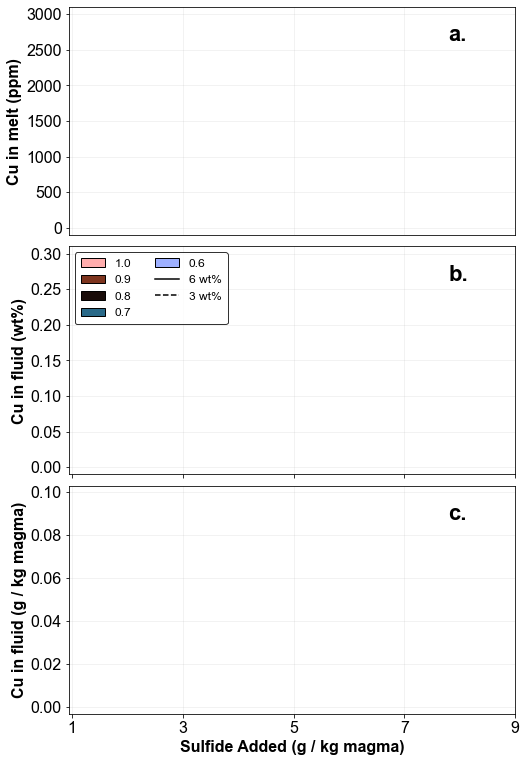

In [44]:
from matplotlib.cm import viridis, cividis
from cmcrameri import cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 16
melt_fractions = compiled_assim.targets.unique()

fig, axs = plt.subplots(3, 1, figsize=(8, 13), sharex=True)

# Set up the normalization for the color bar
norm = Normalize(vmin=melt_fractions.min(), vmax=melt_fractions.max())
sm = plt.cm.ScalarMappable(cmap=cm.berlin, norm=norm)

legend_elements = []

#plotting the wettest case data
for i, melt_fraction in enumerate(melt_fractions):
    df = compiled_assim[compiled_assim.targets == melt_fraction]
    x = 10*df['mass_sulfide_added_g']
    y = df['new_Cmelt_Cu']*10**4
    z = 10 * df['new_Mmelt_Cu']
    
    color = sm.to_rgba(melt_fraction)
    line1, = axs[0].plot(x, y, label=f'{melt_fraction}', color=color)
    
    
#plotting drier case data - commented out until you have run some!    
    #df3 = compiled_assim_dry[compiled_assim_dry.targets == melt_fraction]
    #x = 10*df3['mass_sulfide_added_g']
    #y = df3['new_Cmelt_Cu']*10**4
    #z = 10 * df3['new_Mmelt_Cu']
    #axs[0].plot(x, y, label=f'1 wt% : {melt_fraction}', color=color, linestyle='--')
    
    
#plotting the wettest case data    
for i, melt_fraction in enumerate(melt_fractions):
    df = compiled_assim[compiled_assim.targets == melt_fraction]
    x = 10*df['mass_sulfide_added_g']
    y = df['new_Cfluid_Cu']
    z = 10 * df['new_Mfluid_Cu']
    
    color = sm.to_rgba(melt_fraction)
    line5, = axs[1].plot(x, y, label=f'6 wt% : {melt_fraction}', color=color)
    line6, = axs[2].plot(x, z, color=color)

#plotting drier case data - commented out until you have run some!    
    #df3 = compiled_assim_dry[compiled_assim_dry.targets == melt_fraction]
    #x = 10*df3['mass_sulfide_added_g']
    #y = df3['new_Cfluid_Cu']
    #z = 10 * df3['new_Mfluid_Cu']
    #line7, = axs[1].plot(x, y, label=f'1 wt% : {melt_fraction}', color=color, linestyle='--')
    #line8, = axs[2].plot(x, z, color=color, linestyle='--')

    # Add legend element for each melt fraction
    legend_elements.append(Patch(facecolor=color, edgecolor='black', label=f'{melt_fraction}'))

# Add the legend elements for line styles
legend_elements += [
    Line2D([0], [0], color='black', linestyle='-', label='6 wt%'),
    Line2D([0], [0], color='black', linestyle='--', label='3 wt%')
]


# Add the legend with custom handles
axs[1].legend(handles=legend_elements, frameon=True, edgecolor='k', borderpad=0.5, ncol=2, loc='upper left', fontsize=12)

#axs[1].set_xlabel('Sulfide Added (g / kg magma)',weight='bold')
axs[1].set_ylabel('Cu in fluid (wt%)',weight='bold')
axs[1].grid(True, alpha=0.2)
axs[1].set_ylim(-0.01,0.31)
axs[1].set_yticks([0,0.05,0.1,0.15,0.2,0.25,0.3])

axs[2].set_xlabel('Sulfide Added (g / kg magma)',weight='bold')
axs[2].set_ylabel('Cu in fluid (g / kg magma)',weight='bold')
axs[2].grid(True, alpha=0.2)
axs[2].set_ylim(-0.003,0.103)
 

axs[0].set_ylabel('Cu in melt (ppm)',weight='bold')
axs[0].grid(True, alpha=0.2)
axs[0].set_ylim(-100,3100)



# Remove x-axis ticks and labels for the specified subplots
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

axs[2].set_xticks([1,3,5,7,9])
axs[1].set_xticks([1,3,5,7,9])



import matplotlib.patches as mpatches        
# Create patches and labels for each subplot
if axs.ndim == 1:
    axs = axs.reshape(3, 1)

labels = ['a.', 'b.', 'c.']

for i in range(3):
    # Create a patch in the upper right corner
    ax_row, ax_col = divmod(i, 1)
    # Add the label in the upper right corner using ax.annotate
    axs[ax_row, ax_col].annotate(f'{labels[i]}', xy=(0.85, 0.85), fontsize=22, xycoords='axes fraction', color='black', weight='bold',zorder=5)

plt.subplots_adjust(wspace = 0.18,hspace=0.05)